In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
from scipy import stats
import statsmodels.api as sm

In [3]:
from Bio import SeqIO

____

1. Vf gene list
2. Blast against background reference and against full dataset.
3. Enrichment analysis

___

In [4]:
ref = '../../out/C001-001-P2.emapper.annotations'
wg_associated = '../../out/associations/summary.emapper.annotations'
peu_associated = '../../out/peu/summary.emapper.annotations'
ped_associated = '../../out/ped/summary.emapper.annotations'
b2_associated = '../../out/B2/summary.emapper.annotations'
sampled_pangenome = '../../out/sample.blast.txt'
vgl = '../../data/AllVFs.fasta'
vgc = '../../data/vf_list.txt'

1. Vf gene list

In [5]:
# from Julie's list
idd = []
description = []
with open(vgl) as handle:
    for record in SeqIO.parse(handle, "fasta"):
        idd.append(record.id)
        description.append(record.description)
vgc = pd.read_csv('../../data/vf_list.txt', sep='\t')

In [6]:
# from the sampled pangenome
vf_pangenome = pd.read_csv(sampled_pangenome, sep='\t', header=None)
vf_pangenome.columns = ['qseqid', 'sseqid', 'pident', 'qlen', 'slen', 'length', 'nident']

In [7]:
vgc

,gene,category
0,aafA,adhesin
1,aafA_1,adhesin
2,aafA_2,adhesin
3,aafA_3,adhesin
4,aafA_4,adhesin
...,...,...
1285,ybtS,to define
1286,ybtT,to define
1287,ybtU,to define
1288,ybtX,to define


In [8]:
vf_pangenome.shape

(3070, 7)

In [9]:
# filter rows with > 90% pident
vf_pangenome = vf_pangenome[vf_pangenome['pident'] > 90]

In [10]:
vf_pangenome.shape

(2239, 7)

In [11]:
vf_list = vf_pangenome['sseqid'].unique()

In [12]:
vf_list

array(['group_14057', 'group_14874', 'cba~~~cba_2~~~cba_1', 'cda', 'ceaC',
       'group_23424', 'cnl', 'group_14039', 'group_3454',
       'cma_2~~~~~~cma', 'cma_2', 'group_24308', 'group_22466', 'toxA',
       'group_7469',
       'sepA_1~~~eatA~~~pic~~~sepA~~~espP~~~sepA_2~~~espP_3',
       'group_4334', 'group_22680', 'group_23027', 'group_11361', 'eaeB',
       'espFU', 'sepA_1', 'group_23026', 'group_11967', 'pulD',
       'smf1~~~smf1_1', 'group_7616', 'papB_3', 'faeG', 'group_9314',
       'group_9269', 'group_8397', 'group_9335', 'group_8739', 'faeG_2',
       'group_21210', 'group_2277', 'group_9146', 'group_7308',
       'group_7805', 'group_8076', 'gadA~~~gadB~~~gadB_1', 'group_20458',
       'gadB', 'gadA_2~~~gadA~~~gadB~~~gadB_1', 'group_22671',
       'group_19657', 'group_20046', 'group_19604', 'group_19642',
       'group_22672', 'group_12963', 'hlyA', 'hlyE', 'cirA_2~~~cirA_3',
       'cirA_2~~~btuB_3~~~btuB_1~~~cirA_5~~~cirA_3~~~cirA_4',
       'btuB_2~~~cirA_4', 'ci

In [13]:
# add gene name + category (vgc dataframe) to vf_pangeome

# get list of qseqid
qseqid = vf_pangenome['qseqid']
# get just list of gene name in order
gene = [x.split("~~~")[1] for x in qseqid]
# add column to dataframe with same order
vf_pangenome['gene'] = gene
# merge dataframes at gene col
vf_pangenome = pd.merge(vf_pangenome, vgc, left_on='gene', right_on='gene')
# subset vf_pangenome with col of interest
vff = vf_pangenome[['qseqid', 'sseqid', 'gene', 'category']]

In [14]:
vff.groupby('category').count()

,qseqid,sseqid,gene
category,,,
adhesin,638,638,638
invasin,2,2,2
iron acquisition,174,174,174
miscellanous,740,740,740
protectin,19,19,19
toxin,666,666,666


In [90]:
vff

,qseqid,sseqid,gene,category
0,Septicoli~~~astA_1~~~AF161000,group_14057,astA_1,toxin
1,Septicoli~~~astA_1~~~AF161000,group_14874,astA_1,toxin
2,Septicoli~~~astA_2~~~AF161001,group_14057,astA_2,toxin
3,Septicoli~~~astA_2~~~AF161001,group_14874,astA_2,toxin
4,Septicoli~~~astA_3~~~AB042005,group_14874,astA_3,toxin
...,...,...,...,...
2234,Plasmid_colV~~~sitC~~~sitC,mntB_2~~~mntB_3,sitC,iron acquisition
2235,Plasmid_colV~~~sitD~~~sitD,mntB_2~~~mntB_3~~~mntB_1~~~mntB_4,sitD,iron acquisition
2236,Plasmid_colV~~~sitD~~~sitD,mntB_1~~~mntB_2~~~mntB_3~~~~~~mntB_4,sitD,iron acquisition
2237,Plasmid_colV~~~etsA~~~etsA,macA_2~~~~~~macA_3~~~macA_1,etsA,toxin


____

In [91]:
category = vgc['category'].unique()

In [15]:
m = pd.read_csv(ref, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
m.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
m = m.drop(m.tail(3).index)
m.loc[m.index.difference(m['COG_category'].dropna().index),
      'COG_category'] = 'X'

### **PEU**

For all the collection - taking into account vg or no

In [93]:
u = pd.read_csv(peu_associated, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
u.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
u = u.drop(u.tail(3).index)
u.loc[u.index.difference(u['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [94]:
u[u['query'].isin(vf_list)]

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
23,iucB~~~iucB_1~~~~~~iucB_2,199310.c3626,1.640000e-236,649.0,"COG1670@1|root,COG1670@2|Bacteria,1MWIE@1224|P...",2|Bacteria,J,Siderophore biosynthesis protein,iucB,-,...,"ko:K03894,ko:K03896","ko00310,ko01120,map00310,map01120",-,"R03168,R10090","RC00004,RC00064,RC00090,RC00865","ko00000,ko00001,ko01000",-,-,-,Acetyltransf_8
42,papH~~~papH_2,199310.c3591,5.160000e-146,410.0,"COG3539@1|root,COG3539@2|Bacteria,1RHJU@1224|P...",2|Bacteria,NU,Residues 1 to 195 of 195 are 98.97 pct identic...,-,-,...,-,-,-,-,-,-,-,-,-,-
48,iucB_2~~~iucB_1~~~iucB,198214.SF3716,1.360000e-244,669.0,"COG1670@1|root,COG1670@2|Bacteria,1MWIE@1224|P...",2|Bacteria,J,Siderophore biosynthesis protein,iucB,-,...,"ko:K03894,ko:K03896","ko00310,ko01120,map00310,map01120",-,"R03168,R10090","RC00004,RC00064,RC00090,RC00865","ko00000,ko00001,ko01000",-,-,-,Acetyltransf_8
59,iucC_1~~~iucC_2~~~iucD~~~~~~iucC,199310.c3625,0.000000e+00,1166.0,"COG4264@1|root,COG4264@2|Bacteria,1MVUU@1224|P...",2|Bacteria,Q,Siderophore biosynthesis protein,iucC,-,...,ko:K03895,"ko00310,ko01120,map00310,map01120",-,R10091,"RC00064,RC00090","ko00000,ko00001,ko01000",-,-,-,"FhuF,IucA_IucC"
68,iucC_2~~~iucC_1~~~iucC,198214.SF3717,0.000000e+00,1197.0,"COG4264@1|root,COG4264@2|Bacteria,1MVUU@1224|P...",2|Bacteria,Q,Siderophore biosynthesis protein,iucC,-,...,ko:K03895,"ko00310,ko01120,map00310,map01120",-,R10091,"RC00064,RC00090","ko00000,ko00001,ko01000",-,-,-,"FhuF,IucA_IucC"
74,gadA_2~~~gadA~~~gadB~~~gadB_1,155864.EDL933_2147,4.140000e-166,473.0,"COG0076@1|root,COG0076@2|Bacteria,1MX25@1224|P...",2|Bacteria,E,Converts glutamate to gamma-aminobutyrate (GAB...,gadB,"GO:0003674,GO:0003824,GO:0004351,GO:0005488,GO...",...,ko:K01580,"ko00250,ko00410,ko00430,ko00650,ko01100,ko0111...",M00027,"R00261,R00489,R01682,R02466",RC00299,"ko00000,ko00001,ko00002,ko01000",-,-,"iECUMN_1333.ECUMN_1747,iUTI89_1310.UTI89_C1707...",Pyridoxal_deC


In [95]:
res = []
pop_c = m[m['query'].isin(vf_list)].shape[0]
pop_n = m[~m['query'].isin(vf_list)].shape[0]

study_c = u[u['query'].isin(vf_list)].shape[0]
study_n = u[~u['query'].isin(vf_list)].shape[0]

table = [[study_c, pop_c],
        [study_n, pop_n]]
odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')

# empirical
ratios = []
for _ in range(100):
    pop_c = m[m['query'].isin(vf_list)].shape[0]
    pop_n = m[~m['query'].isin(vf_list)].shape[0]
        
    r = m.sample(u.shape[0])
    study_r_c = r[r['query'].isin(vf_list)].shape[0]
    study_r_n = r[~r['query'].isin(vf_list)].shape[0]
        
    table = [[study_r_c, pop_c],
            [study_r_n, pop_n]]
    ratios.append(stats.fisher_exact(table, alternative='greater')[0])

zscores = stats.zscore(ratios + [odds_ratio])
pvalues = stats.norm.sf(abs(zscores))
qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
res.append((vf_list, pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['virulence_gene', 'pvalue', 'empirical-qvalue'])

In [96]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['virulence_gene', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [97]:
r

,virulence_gene,pvalue,qvalue,empirical-qvalue
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.001502,0.001502,0.002163


In [98]:
peu_vf = r.copy()

## PED

In [99]:
d = pd.read_csv(ped_associated, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
d.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
d = d.drop(d.tail(3).index)
d.loc[d.index.difference(d['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [102]:
d[d['query'].isin(vf_list)]

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
20,iucC_1~~~iucC_2~~~iucD~~~~~~iucC,199310.c3625,0.0,1166.0,"COG4264@1|root,COG4264@2|Bacteria,1MVUU@1224|P...",2|Bacteria,Q,Siderophore biosynthesis protein,iucC,-,...,ko:K03895,"ko00310,ko01120,map00310,map01120",-,R10091,"RC00064,RC00090","ko00000,ko00001,ko01000",-,-,-,"FhuF,IucA_IucC"
22,iucC_2~~~iucC_1~~~iucC,198214.SF3717,0.0,1188.0,"COG4264@1|root,COG4264@2|Bacteria,1MVUU@1224|P...",2|Bacteria,Q,Siderophore biosynthesis protein,iucC,-,...,ko:K03895,"ko00310,ko01120,map00310,map01120",-,R10091,"RC00064,RC00090","ko00000,ko00001,ko01000",-,-,-,"FhuF,IucA_IucC"


In [103]:
d[~d['query'].isin(vf_list)]

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
0,yhdJ_1~~~~~~yhdJ_2~~~yhdJ_3,198214.CP0198,3.430000e-169,471.0,"COG0863@1|root,COG0863@2|Bacteria,1R7KV@1224|P...",2|Bacteria,L,Belongs to the N(4) N(6)-methyltransferase family,VP0394,-,...,"ko:K00571,ko:K07319",-,-,-,-,"ko00000,ko01000,ko02048",-,-,-,N6_N4_Mtase
1,purH,155864.EDL933_5338,0.000000e+00,1016.0,"COG0138@1|root,COG0138@2|Bacteria,1MUDQ@1224|P...",2|Bacteria,F,Bifunctional purine biosynthesis protein PurH,purH,"GO:0003674,GO:0003824,GO:0003937,GO:0004643,GO...",...,ko:K00602,"ko00230,ko00670,ko01100,ko01110,ko01130,ko0152...",M00048,"R01127,R04560","RC00026,RC00263,RC00456","ko00000,ko00001,ko00002,ko01000,ko04147",-,-,"iEcHS_1320.EcHS_A4240,iPC815.YPO3728","AICARFT_IMPCHas,MGS"
2,ptrB~~~ptrB_2~~~~~~ptrB_1,362663.ECP_1789,0.000000e+00,1408.0,"COG1770@1|root,COG1770@2|Bacteria,1MUED@1224|P...",2|Bacteria,E,oligopeptidase activity,ptrB,"GO:0003674,GO:0003824,GO:0004175,GO:0004252,GO...",...,ko:K01354,"ko05142,ko05143,map05142,map05143",-,-,-,"ko00000,ko00001,ko01000,ko01002",-,-,-,"Peptidase_S9,Peptidase_S9_N"
3,hscA_2~~~hscA_1~~~hscA,155864.EDL933_3688,0.000000e+00,1155.0,"COG0443@1|root,COG0443@2|Bacteria,1MVQI@1224|P...",2|Bacteria,O,Chaperone involved in the maturation of iron-s...,hscA,"GO:0000166,GO:0000988,GO:0000989,GO:0003674,GO...",...,"ko:K04043,ko:K04044","ko03018,ko04212,ko05152,map03018,map04212,map0...",-,-,-,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147","1.A.33,1.A.33.1",-,-,HSP70
4,xerC_5~~~xerC_6~~~xerC_9~~~xerC_4~~~xerC_2~~~x...,155864.EDL933_p0051,4.830000e-174,485.0,"COG0582@1|root,COG0582@2|Bacteria,1R8ME@1224|P...",2|Bacteria,L,Phage integrase family,-,-,...,-,-,-,-,-,-,-,-,-,Phage_integrase
5,epmB,199310.c5231,6.290000e-250,685.0,"COG1509@1|root,COG1509@2|Bacteria,1MUPJ@1224|P...",2|Bacteria,C,With EpmA is involved in the beta-lysylation s...,kamA,"GO:0003674,GO:0003824,GO:0005488,GO:0016853,GO...",...,"ko:K01843,ko:K19810","ko00310,map00310",-,R00461,RC00303,"ko00000,ko00001,ko01000,ko03012",-,-,"iECH74115_1262.ECH74115_5662,iECIAI39_1322.ECI...","Fer4_12,Radical_SAM"
6,group_4435,155864.EDL933_2464,6.460000e-83,245.0,"2CCI6@1|root,32RVS@2|Bacteria,1MZ8H@1224|Prote...",2|Bacteria,S,tail assembly chaperone,-,-,...,-,-,-,-,-,-,-,-,-,-
7,group_14181,754331.AEME01000001_gene2191,0.000000e+00,1051.0,"COG0286@1|root,COG0286@2|Bacteria,1MW3A@1224|P...",2|Bacteria,V,N-6 DNA Methylase,hsdM,-,...,ko:K03427,-,-,-,-,"ko00000,ko01000,ko02048",-,-,-,"HsdM_N,N6_Mtase"
8,tnpR_1~~~tnpR,214092.5832506,1.180000e-102,300.0,"COG1961@1|root,COG1961@2|Bacteria,1R482@1224|P...",2|Bacteria,L,"Resolvase, N terminal domain",tnpR,-,...,-,-,-,-,-,-,-,-,-,"HTH_7,Resolvase"
9,ppk~~~ppk_1~~~ppk_2,155864.EDL933_3657,0.000000e+00,1360.0,"COG0855@1|root,COG0855@2|Bacteria,1MUM3@1224|P...",2|Bacteria,F,Catalyzes the reversible transfer of the termi...,ppk,"GO:0000166,GO:0003674,GO:0003824,GO:0005488,GO...",...,ko:K00937,"ko00190,ko03018,map00190,map03018",-,-,-,"ko00000,ko00001,ko01000,ko03019",-,-,iSbBS512_1146.SbBS512_E2875,"PP_kinase,PP_kinase_C,PP_kinase_N"


In [109]:
res = []
pop_c = m[m['query'].isin(vf_list)].shape[0]
pop_n = m[~m['query'].isin(vf_list)].shape[0]

study_c = d[d['query'].isin(vf_list)].shape[0]
study_n = d[~d['query'].isin(vf_list)].shape[0]

table = [[study_c, pop_c],
        [study_n, pop_n]]
odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')

# empirical
ratios = []
for _ in range(100):
    pop_c = m[m['query'].isin(vf_list)].shape[0]
    pop_n = m[~m['query'].isin(vf_list)].shape[0]
        
    r = m.sample(d.shape[0])
    study_r_c = r[r['query'].isin(vf_list)].shape[0]
    study_r_n = r[~r['query'].isin(vf_list)].shape[0]
        
    table = [[study_r_c, pop_c],
            [study_r_n, pop_n]]
    ratios.append(stats.fisher_exact(table, alternative='greater')[0])

zscores = stats.zscore(ratios + [odds_ratio])
pvalues = stats.norm.sf(abs(zscores))
qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
res.append((vf_list, pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['virulence_gene', 'pvalue', 'empirical-qvalue'])

In [110]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['virulence_gene', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [111]:
r

,virulence_gene,pvalue,qvalue,empirical-qvalue
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.047884,0.047884,0.02541


In [112]:
ped_vf = r.copy()

## B2

In [113]:
b = pd.read_csv(b2_associated, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
b.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
b = b.drop(b.tail(3).index)
b.loc[b.index.difference(b['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [114]:
b[b['query'].isin(vf_list)]

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs


In [115]:
res = []
pop_c = m[m['query'].isin(vf_list)].shape[0]
pop_n = m[~m['query'].isin(vf_list)].shape[0]

study_c = b[b['query'].isin(vf_list)].shape[0]
study_n = b[~b['query'].isin(vf_list)].shape[0]

table = [[study_c, pop_c],
        [study_n, pop_n]]
odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')

# empirical
ratios = []
for _ in range(100):
    pop_c = m[m['query'].isin(vf_list)].shape[0]
    pop_n = m[~m['query'].isin(vf_list)].shape[0]
        
    r = m.sample(b.shape[0])
    study_r_c = r[r['query'].isin(vf_list)].shape[0]
    study_r_n = r[~r['query'].isin(vf_list)].shape[0]
        
    table = [[study_r_c, pop_c],
            [study_r_n, pop_n]]
    ratios.append(stats.fisher_exact(table, alternative='greater')[0])

zscores = stats.zscore(ratios + [odds_ratio])
pvalues = stats.norm.sf(abs(zscores))
qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
res.append((vf_list, pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['virulence_gene', 'pvalue', 'empirical-qvalue'])

In [117]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['virulence_gene', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [118]:
r

,virulence_gene,pvalue,qvalue,empirical-qvalue
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",1.0,1.0,0.308639


In [119]:
b2_vf = r.copy()

## WG

In [120]:
f = pd.read_csv(wg_associated, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
f.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
f = f.drop(f.tail(3).index)
f.loc[f.index.difference(f['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [121]:
f[f['query'].isin(vf_list)]

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
26,kpsD~~~kpsD_1,199310.c3688,0.000000e+00,1070.0,"COG1596@1|root,COG1596@2|Bacteria,1QI9X@1224|P...",2|Bacteria,M,Polysaccharide biosynthesis/export protein,kpsD,-,...,ko:K01991,"ko02026,map02026",-,-,-,"ko00000,ko00001,ko02000",1.B.18,-,-,"Poly_export,SLBB"
40,fimA_2~~~fimA~~~fimA_3~~~fimA_1,316407.85677057,3.740000e-110,318.0,"COG3539@1|root,COG3539@2|Bacteria,1QI7Y@1224|P...",2|Bacteria,NU,"Fimbriae (also called pili), polar filaments r...",fimA,"GO:0003674,GO:0005488,GO:0005515,GO:0005575,GO...",...,ko:K07345,"ko05133,map05133",-,-,-,"ko00000,ko00001,ko02035,ko02044",-,-,-,Fimbrial
49,kpsT~~~kpsT_1,1115512.EH105704_02_02300,1.720000e-113,330.0,"COG1134@1|root,COG1134@2|Bacteria,1MWWC@1224|P...",2|Bacteria,GM,ATPases associated with a variety of cellular ...,kpsT,-,...,"ko:K09689,ko:K09691","ko02010,map02010","M00249,M00250",-,-,"ko00000,ko00001,ko00002,ko01000,ko02000","3.A.1.101,3.A.1.103",-,-,ABC_tran
50,group_5296,316407.85676818,4.850000e-213,599.0,"COG1357@1|root,COG1357@2|Bacteria,1QGYJ@1224|P...",2|Bacteria,S,Pentapeptide repeats (9 copies),yjcF,-,...,-,-,-,-,-,-,-,-,-,Pentapeptide


In [139]:
res = []
pop_c = m[m['query'].isin(vf_list)].shape[0]
pop_n = m[~m['query'].isin(vf_list)].shape[0]

study_c = f[f['query'].isin(vf_list)].shape[0]
study_n = f[~f['query'].isin(vf_list)].shape[0]

table = [[study_c, pop_c],
        [study_n, pop_n]]
odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')

# empirical
ratios = []
for _ in range(100):
    pop_c = m[m['query'].isin(vf_list)].shape[0]
    pop_n = m[~m['query'].isin(vf_list)].shape[0]
        
    r = m.sample(f.shape[0])
    study_r_c = r[r['query'].isin(vf_list)].shape[0]
    study_r_n = r[~r['query'].isin(vf_list)].shape[0]
        
    table = [[study_r_c, pop_c],
            [study_r_n, pop_n]]
    ratios.append(stats.fisher_exact(table, alternative='greater')[0])

zscores = stats.zscore(ratios + [odds_ratio])
pvalues = stats.norm.sf(abs(zscores))
qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
res.append((vf_list, pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['virulence_gene', 'pvalue', 'empirical-qvalue'])

In [140]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['virulence_gene', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [141]:
r

,virulence_gene,pvalue,qvalue,empirical-qvalue
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.011479,0.011479,0.026745


In [142]:
full_vf = r.copy()

**PLOT**

In [42]:
peu_vf
ped_vf
b2_vf
full_vf

,virulence_gene,pvalue,qvalue,empirical-qvalue
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.011479,0.011479,0.05019


In [143]:
full_vf['type'] = ['Full dataset' if x != 0
               else 0
               for x in full_vf['pvalue']]
peu_vf['type'] = ['PE: Urinary tract' if x != 0
               else 0
               for x in peu_vf['pvalue']]
ped_vf['type'] = ['PE: Digestive tract' if x != 0
               else 0
               for x in ped_vf['pvalue']]

In [144]:
ff = pd.concat([full_vf, peu_vf, ped_vf, b2_vf])

In [145]:
ff

,virulence_gene,pvalue,qvalue,empirical-qvalue,type
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.011479,0.011479,0.026745,Full dataset
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.001502,0.001502,0.002163,PE: Urinary tract
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.047884,0.047884,0.025410,PE: Digestive tract
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",1.000000,1.000000,0.308639,B2 strains


In [146]:
ff['log pvalue'] = np.log10(ff['empirical-qvalue'])

In [147]:
ff['-log pvalue'] = -ff['log pvalue']

In [148]:
ff[ff['empirical-qvalue'] < 0.05]

,virulence_gene,pvalue,qvalue,empirical-qvalue,type,log pvalue,-log pvalue
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.011479,0.011479,0.026745,Full dataset,-1.572758,1.572758
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.001502,0.001502,0.002163,PE: Urinary tract,-2.664971,2.664971
0,"[group_14057, group_14874, cba~~~cba_2~~~cba_1...",0.047884,0.047884,0.025410,PE: Digestive tract,-1.594987,1.594987


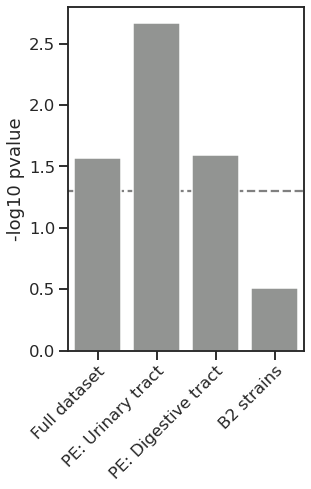

In [149]:
cp = sns.catplot(data=ff,
                 dodge=True,
                 legend=None,
                 height=6,
                 aspect=0.8,
                 kind='bar',
                 x='type', y='-log pvalue',
                 palette=['xkcd:grey'])
for ax in cp.axes_dict.values():
    ax.axvline(1, color='grey', ls='dashed', zorder=0)
cp.set_xlabels('')
cp.set_ylabels('-log10 pvalue')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
sns.despine(top=False,
            right=False)
plt.axhline(-np.log10(0.05), color='grey', ls='dashed', zorder=0)

plt.savefig('../../out/figures/vf_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/vf_all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

#### **For each VF category**

In [150]:
vff

,qseqid,sseqid,gene,category
0,Septicoli~~~astA_1~~~AF161000,group_14057,astA_1,toxin
1,Septicoli~~~astA_1~~~AF161000,group_14874,astA_1,toxin
2,Septicoli~~~astA_2~~~AF161001,group_14057,astA_2,toxin
3,Septicoli~~~astA_2~~~AF161001,group_14874,astA_2,toxin
4,Septicoli~~~astA_3~~~AB042005,group_14874,astA_3,toxin
...,...,...,...,...
2234,Plasmid_colV~~~sitC~~~sitC,mntB_2~~~mntB_3,sitC,iron acquisition
2235,Plasmid_colV~~~sitD~~~sitD,mntB_2~~~mntB_3~~~mntB_1~~~mntB_4,sitD,iron acquisition
2236,Plasmid_colV~~~sitD~~~sitD,mntB_1~~~mntB_2~~~mntB_3~~~~~~mntB_4,sitD,iron acquisition
2237,Plasmid_colV~~~etsA~~~etsA,macA_2~~~~~~macA_3~~~macA_1,etsA,toxin


# PEU

In [151]:
res = []
for categ in category:
    pop_c = m[m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
    pop_n = m[~m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]

    study_c = u[u['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
    study_n = u[~u['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]

    table = [[study_c, pop_c],
             [study_n, pop_n]]
    odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')
        
    # empirical
    ratios = []
    for _ in range(100):
        pop_c = m[m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        pop_n = m[~m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        
        r = m.sample(u.shape[0])
        study_r_c = r[r['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        study_r_n = r[~r['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        
        table = [[study_r_c, pop_c],
                 [study_r_n, pop_n]]
        ratios.append(stats.fisher_exact(table, alternative='greater')[0])

    zscores = stats.zscore(ratios + [odds_ratio])
    pvalues = stats.norm.sf(abs(zscores))
    qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
    res.append((categ, pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['VF category', 'pvalue', 'empirical-qvalue'])

In [152]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['VF category', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [153]:
r

,VF category,pvalue,qvalue,empirical-qvalue
0,adhesin,0.273154,0.637359,0.285482
1,toxin,1.000000,1.000000,0.377227
2,miscellanous,0.068343,0.239201,0.003328
3,invasin,1.000000,1.000000,0.443487
4,protectin,1.000000,1.000000,0.370135
5,iron acquisition,0.003737,0.026156,0.000932
6,to define,1.000000,1.000000,NaN


In [154]:
r[r['empirical-qvalue'] < 0.05]

,VF category,pvalue,qvalue,empirical-qvalue
2,miscellanous,0.068343,0.239201,0.003328
5,iron acquisition,0.003737,0.026156,0.000932


In [155]:
peu_cat = r.copy()

# PED

In [161]:
res = []
for categ in category:
    pop_c = m[m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
    pop_n = m[~m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]

    study_c = d[d['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
    study_n = d[~d['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]

    table = [[study_c, pop_c],
             [study_n, pop_n]]
    odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')
        
    # empirical
    ratios = []
    for _ in range(100):
        pop_c = m[m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        pop_n = m[~m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        
        r = m.sample(d.shape[0])
        study_r_c = r[r['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        study_r_n = r[~r['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        
        table = [[study_r_c, pop_c],
                 [study_r_n, pop_n]]
        ratios.append(stats.fisher_exact(table, alternative='greater')[0])

    zscores = stats.zscore(ratios + [odds_ratio])
    pvalues = stats.norm.sf(abs(zscores))
    qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
    res.append((categ, pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['VF category', 'pvalue', 'empirical-qvalue'])

In [162]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['VF category', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [163]:
r

,VF category,pvalue,qvalue,empirical-qvalue
0,adhesin,1.000000,1.00000,0.399650
1,toxin,1.000000,1.00000,0.419540
2,miscellanous,1.000000,1.00000,0.460172
3,invasin,1.000000,1.00000,0.443487
4,protectin,1.000000,1.00000,0.419540
5,iron acquisition,0.013874,0.09712,0.000463
6,to define,1.000000,1.00000,NaN


In [164]:
r[r['empirical-qvalue'] < 0.05]

,VF category,pvalue,qvalue,empirical-qvalue
5,iron acquisition,0.013874,0.09712,0.000463


In [165]:
ped_cat = r.copy()

# B2

In [166]:
res = []
for categ in category:
    pop_c = m[m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
    pop_n = m[~m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]

    study_c = b[b['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
    study_n = b[~b['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]

    table = [[study_c, pop_c],
             [study_n, pop_n]]
    odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')
        
    # empirical
    ratios = []
    for _ in range(100):
        pop_c = m[m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        pop_n = m[~m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        
        r = m.sample(b.shape[0])
        study_r_c = r[r['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        study_r_n = r[~r['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        
        table = [[study_r_c, pop_c],
                 [study_r_n, pop_n]]
        ratios.append(stats.fisher_exact(table, alternative='greater')[0])

    zscores = stats.zscore(ratios + [odds_ratio])
    pvalues = stats.norm.sf(abs(zscores))
    qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
    res.append((categ, pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['VF category', 'pvalue', 'empirical-qvalue'])

In [167]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['VF category', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [168]:
r

,VF category,pvalue,qvalue,empirical-qvalue
0,adhesin,1.0,1.0,0.343238
1,toxin,1.0,1.0,0.400786
2,miscellanous,1.0,1.0,0.443487
3,invasin,1.0,1.0,NaN
4,protectin,1.0,1.0,0.430554
5,iron acquisition,1.0,1.0,0.308120
6,to define,1.0,1.0,NaN


In [169]:
b2_cat = r.copy()

# WG

In [170]:
f[f['query'].isin(vf_list)]

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
26,kpsD~~~kpsD_1,199310.c3688,0.000000e+00,1070.0,"COG1596@1|root,COG1596@2|Bacteria,1QI9X@1224|P...",2|Bacteria,M,Polysaccharide biosynthesis/export protein,kpsD,-,...,ko:K01991,"ko02026,map02026",-,-,-,"ko00000,ko00001,ko02000",1.B.18,-,-,"Poly_export,SLBB"
40,fimA_2~~~fimA~~~fimA_3~~~fimA_1,316407.85677057,3.740000e-110,318.0,"COG3539@1|root,COG3539@2|Bacteria,1QI7Y@1224|P...",2|Bacteria,NU,"Fimbriae (also called pili), polar filaments r...",fimA,"GO:0003674,GO:0005488,GO:0005515,GO:0005575,GO...",...,ko:K07345,"ko05133,map05133",-,-,-,"ko00000,ko00001,ko02035,ko02044",-,-,-,Fimbrial
49,kpsT~~~kpsT_1,1115512.EH105704_02_02300,1.720000e-113,330.0,"COG1134@1|root,COG1134@2|Bacteria,1MWWC@1224|P...",2|Bacteria,GM,ATPases associated with a variety of cellular ...,kpsT,-,...,"ko:K09689,ko:K09691","ko02010,map02010","M00249,M00250",-,-,"ko00000,ko00001,ko00002,ko01000,ko02000","3.A.1.101,3.A.1.103",-,-,ABC_tran
50,group_5296,316407.85676818,4.850000e-213,599.0,"COG1357@1|root,COG1357@2|Bacteria,1QGYJ@1224|P...",2|Bacteria,S,Pentapeptide repeats (9 copies),yjcF,-,...,-,-,-,-,-,-,-,-,-,Pentapeptide


In [171]:
res = []
for categ in category:
    pop_c = m[m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
    pop_n = m[~m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]

    study_c = f[f['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
    study_n = f[~f['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]

    table = [[study_c, pop_c],
             [study_n, pop_n]]
    odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')
        
    # empirical
    ratios = []
    for _ in range(100):
        pop_c = m[m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        pop_n = m[~m['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        
        r = m.sample(f.shape[0])
        study_r_c = r[r['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        study_r_n = r[~r['query'].isin(vff[vff['category'] == categ]['sseqid'])].shape[0]
        
        table = [[study_r_c, pop_c],
                 [study_r_n, pop_n]]
        ratios.append(stats.fisher_exact(table, alternative='greater')[0])

    zscores = stats.zscore(ratios + [odds_ratio])
    pvalues = stats.norm.sf(abs(zscores))
    qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
    res.append((categ, pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['VF category', 'pvalue', 'empirical-qvalue'])

In [172]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['VF category', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [173]:
r

,VF category,pvalue,qvalue,empirical-qvalue
0,adhesin,0.205564,0.479649,1.209504e-01
1,toxin,0.085507,0.299275,1.787850e-03
2,miscellanous,1.000000,1.000000,4.007863e-01
3,invasin,1.000000,1.000000,4.601722e-01
4,protectin,0.004214,0.029501,9.213075e-09
5,iron acquisition,1.000000,1.000000,2.666006e-01
6,to define,1.000000,1.000000,NaN


In [174]:
wg_cat = r.copy()

## plot

In [71]:
peu_cat
ped_cat
b2_cat
wg_cat

,VF category,pvalue,qvalue,empirical-qvalue
0,adhesin,0.205564,0.479649,NaN
1,toxin,0.085507,0.299275,NaN
2,miscellanous,1.000000,1.000000,NaN
3,invasin,1.000000,1.000000,NaN
4,protectin,0.004214,0.029501,NaN
5,iron acquisition,1.000000,1.000000,NaN
6,to define,1.000000,1.000000,NaN


In [182]:
wg_cat['type'] = ['Full collection' if x != 0
               else 0
               for x in wg_cat['pvalue']]
peu_cat['type'] = ['PE: Urinary tract' if x != 0
               else 0
               for x in peu_cat['pvalue']]
ped_cat['type'] = ['PE: Digestive tract' if x != 0
               else 0
               for x in ped_cat['pvalue']]
b2_cat['type'] = ['B2 strains' if x != 0
               else 0
               for x in b2_cat['pvalue']]

In [189]:
peu_cat['log pvalue'] = np.log10(peu_cat['empirical-qvalue'])
peu_cat['-log pvalue'] = -peu_cat['log pvalue']

In [183]:
tt = pd.concat([wg_cat, peu_cat, ped_cat, b2_cat])

In [184]:
tt['log pvalue'] = np.log10(tt['empirical-qvalue'])

In [185]:
tt['-log pvalue'] = -tt['log pvalue']

In [187]:
tt[tt['empirical-qvalue'] < 0.05]

,VF category,pvalue,qvalue,empirical-qvalue,type,log pvalue,-log pvalue
1,toxin,0.085507,0.299275,1.787850e-03,Full collection,-2.747669,2.747669
4,protectin,0.004214,0.029501,9.213075e-09,Full collection,-8.035595,8.035595
2,miscellanous,0.068343,0.239201,3.328192e-03,PE: Urinary tract,-2.477792,2.477792
5,iron acquisition,0.003737,0.026156,9.318105e-04,PE: Urinary tract,-3.030672,3.030672
5,iron acquisition,0.013874,0.097120,4.634886e-04,PE: Digestive tract,-3.333961,3.333961


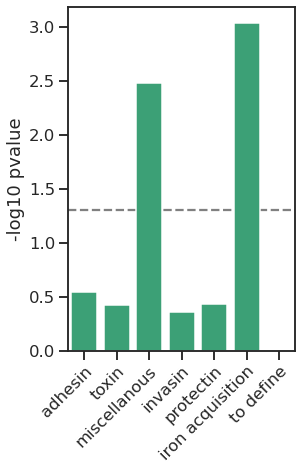

In [206]:
cp = sns.catplot(data=peu_cat,
                 x='VF category', y='-log pvalue',
                 hue = 'type',
                 height=6,
                 aspect=0.8,
                 legend=False,
                 kind='bar',
                 dodge=True,
                 palette=['xkcd:bluey green'])

plt.xlabel("")
plt.ylabel("-log10 pvalue")
sns.despine(top=False,
            right=False)
plt.axhline(-np.log10(0.05), color='grey', ls='dashed', zorder=0)

plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.savefig('../../out/figures/vf_peu.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/vf_peu.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

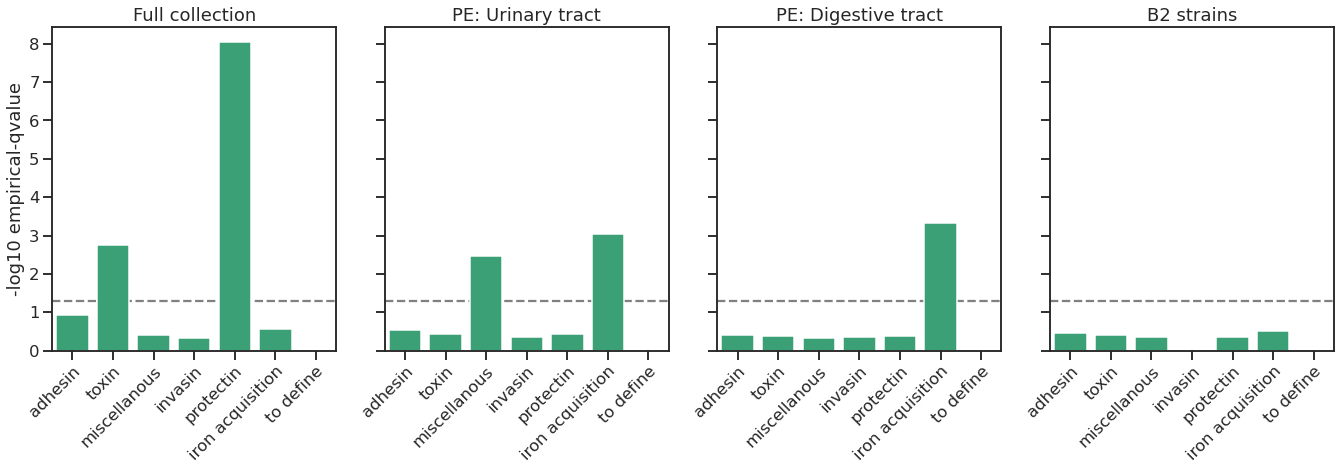

In [208]:
cp = sns.catplot(data=tt,
                 x='VF category', y='-log pvalue',
                 col='type',
                 col_order=['Full collection', 'PE: Urinary tract', 'PE: Digestive tract', 'B2 strains'],
                 height=6,
                 aspect=0.8,
                 legend=True,
                 kind='bar',
                 dodge=True,
                 palette=['xkcd:bluey green'])

sns.despine(top=False,
            right=False)

ax1, ax2, ax3, ax4 = cp.axes[0]
ax1.axhline(-np.log10(0.05), color='grey', ls='dashed', zorder=0)
ax2.axhline(-np.log10(0.05), color='grey', ls='dashed', zorder=0)
ax3.axhline(-np.log10(0.05), color='grey', ls='dashed', zorder=0)
ax4.axhline(-np.log10(0.05), color='grey', ls='dashed', zorder=0)


xticklabels=['adhesin', 'toxin', 'miscellanous', 'invasin', 'protectin', 'iron acquisition', 'to define']
ax1.set_xticklabels(xticklabels, rotation=45, ha='right', rotation_mode='anchor')
ax2.set_xticklabels(xticklabels, rotation=45, ha='right', rotation_mode='anchor')
ax3.set_xticklabels(xticklabels, rotation=45, ha='right', rotation_mode='anchor')
ax4.set_xticklabels(xticklabels, rotation=45, ha='right', rotation_mode='anchor')

ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")

ax1.set_ylabel("-log10 empirical-qvalue")

cp.set_titles(col_template='{col_name}')


plt.savefig('../../out/figures/vf_pass.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/vf_pass.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);